In [56]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D, MaxPooling2D, UpSampling2D, Reshape, Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.optimizers import SGD, Adam
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile
from keras.utils import plot_model

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Load the audio data

In [3]:
multitracks = mdb.load_multitracks([
    "Phoenix_ColliersDaughter", 
    "Phoenix_BrokenPledgeChicagoReel", 
    "Phoenix_ElzicsFarewell", 
    "Phoenix_LarkOnTheStrandDrummondCastle",
    "Phoenix_ScotchMorris",
    "Phoenix_SeanCaughlinsTheScartaglen"
])

In [4]:
mix_audio = None
instrument_audio = None

for mix in multitracks:
    sample_rate, song = wavfile.read(mix.mix_path)
    
    if mix_audio is None:
        mix_audio = song
    
    else:
        mix_audio = np.concatenate((mix_audio, song))
    
    #
    
    instruments = mdb.get_files_for_instrument("violin", [mix])

    instrument = next(instruments)
    
    sample_rate, track = wavfile.read(instrument)
    
    if instrument_audio is None:
        instrument_audio = track
    
    else:
        instrument_audio = np.concatenate((instrument_audio, track))
    
mix_audio = mix_audio.mean(1)
instrument_audio = instrument_audio.mean(1)

In [5]:
samples_per_period = 512
overlap = int(samples_per_period/2)

# Process the Mix

In [6]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

In [7]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))
#plt.title("STFT of the Mix")
#plt.ylabel("Frequency (Hz)")
#plt.xlabel("Time (s)")

# Process the Target Instrument

In [8]:
_, _, s_instrument = signal.stft(instrument_audio, fs=sample_rate, nfft=samples_per_period, 
                                               noverlap=overlap, nperseg=samples_per_period)

s_instrument = s_instrument[:-1,:]

s_instrument += 1e-9

In [9]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_instrument)))
#plt.title("STFT of the instrument Track")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (Hz)")

# Prepare the training data

In [10]:
num_test  = int((sample_rate * 120)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

187372 10335


In [11]:
mix_train = s_mix.T[:num_train,np.newaxis,:]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=1)
mix_train.shape

(187372, 2, 256)

In [12]:
instrument_train = s_instrument.T[:num_train,np.newaxis,:]
instrument_train = np.concatenate((instrument_train.real, instrument_train.imag), axis=1)
instrument_train.shape

(187372, 2, 256)

In [13]:
mix_test = s_mix.T[-num_test+1:,np.newaxis,:]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=1)
mix_test.shape

(10334, 2, 256)

In [14]:
instrument_test = s_instrument.T[-num_test+1:,np.newaxis,:]
instrument_test = np.concatenate((instrument_test.real, instrument_test.imag), axis=1)
instrument_test.shape

(10334, 2, 256)

In [52]:
model = Sequential()

model.add(Dense(256, input_shape=mix_train.shape[1:], kernel_initializer="glorot_uniform", activation="relu"))

model.add(Conv1D(256, 4, padding="same", activation="relu"))

model.add(Conv1D(128, 4, padding="same", activation="relu"))

model.add(Dropout(0.2))

model.add(Dense(128, activation="relu", kernel_initializer="glorot_uniform"))

model.add(Conv1D(64, 4, padding="same", activation="relu"))

model.add(Conv1D(32, 4, padding="same", activation="relu"))

model.add(Dropout(0.2))

model.add(Dense(256, activation="relu", kernel_initializer="glorot_uniform"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 2, 256)            65792     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 2, 256)            262400    
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 2, 128)            131200    
_________________________________________________________________
dropout_13 (Dropout)         (None, 2, 128)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 2, 128)            16512     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 2, 64)             32832     
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 2, 32)             8224      
__________

In [53]:
plot_model(model, to_file='model.png')

In [54]:
adam = Adam(lr=1e-3, beta_1=0.8, beta_2=0.9, epsilon=1e-9, decay=0.0, amsgrad=False)

#sgd = SGD(lr=0.001, momentum=1.1, decay=1.1, nesterov=True)

model.compile(adam, loss='mean_squared_error', metrics=['accuracy'])

In [57]:
history = model.fit(mix_train, instrument_train, batch_size=200, epochs=10000)

Epoch 1/10000
187372/187372 [==============================] - 7s 37us/step - loss: 1042.6358 - acc: 0.4292
Epoch 2/10000
187372/187372 [==============================] - 7s 37us/step - loss: 1042.8986 - acc: 0.4313
Epoch 3/10000
187372/187372 [==============================] - 7s 37us/step - loss: 1042.0655 - acc: 0.4288
Epoch 4/10000
187372/187372 [==============================] - 7s 38us/step - loss: 1042.3246 - acc: 0.4293
Epoch 5/10000
187372/187372 [==============================] - 7s 39us/step - loss: 1042.2927 - acc: 0.4315
Epoch 6/10000
187372/187372 [==============================] - 7s 38us/step - loss: 1042.1437 - acc: 0.4317
Epoch 7/10000
187372/187372 [==============================] - 7s 38us/step - loss: 1042.1467 - acc: 0.4294
Epoch 8/10000
187372/187372 [==============================] - 7s 37us/step - loss: 1041.4809 - acc: 0.4308
Epoch 9/10000
187372/187372 [==============================] - 7s 37us/step - loss: 1042.3460 - acc: 0.4316
Epoch 10/10000
143600/187372

KeyboardInterrupt: 

In [58]:
results = model.evaluate(mix_test, instrument_test)

print(model.metrics_names)
print(results)

10334/10334 [==============================] - 1s 91us/step
['loss', 'acc']
[1410.214272817404, 0.3499612928198181]


# Results

In [59]:
prediction = model.predict(mix_test)
prediction.shape

(10334, 2, 256)

In [60]:
target = s_instrument[:, -num_test:]

In [61]:
prediction = (prediction[:,0,:]+prediction[:,1,:] * 1j).T
prediction += 1e-9

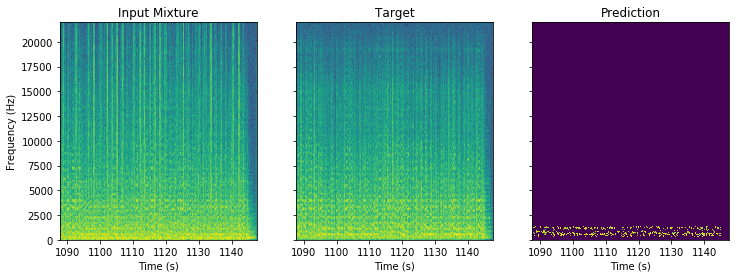

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Prediction")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Time (s)")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [77]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)
_, target_audio = signal.istft(target, fs=sample_rate)
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

wavfile.write("deep_dense_conv_model_instrument_prediction.wav", sample_rate, predicted_audio.astype(np.int16))
wavfile.write("deep_dense_conv_model_instrument_target.wav", sample_rate, target_audio.astype(np.int16))
wavfile.write("deep_dense_conv_model_original.wav", sample_rate, mix_audio.astype(np.int16))